In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install face_recognition

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

LOAD DATA


In [ ]:
!unzip "/content/drive/MyDrive/machine learning/UIT.zip"

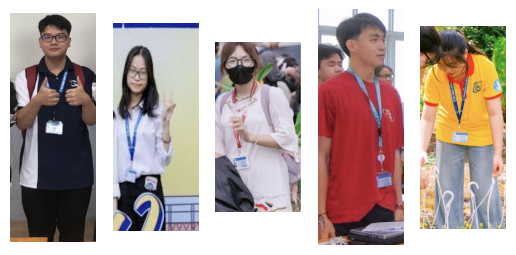

In [6]:
#Visualize some images with named tag labels in the test set
import os
from PIL import Image
import matplotlib.pyplot as plt

dataset_path = '/content/UIT/train/with_name_tag'

image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

num_images_to_display = 5

for i in range(num_images_to_display):
    img_path = os.path.join(dataset_path, image_files[i])
    img = Image.open(img_path)

    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()


PREPROCESSING STEP

In [6]:
import face_recognition
import cv2
from PIL import Image, ImageDraw
from IPython.display import display

def remove_head(image_path):
  try:
    image = face_recognition.load_image_file(image_path)
    original_image = Image.open(image_path)

    # Find all face locations in the image
    face_locations = face_recognition.face_locations(image)

    # Convert the image to a PIL Image so we can draw on it
    pil_image = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_image)

    # Loop through each face location and draw a bounding box
    for face_location in face_locations:
        top, right, bottom, left = face_location

    cropped_image = original_image.crop((0, bottom, original_image.size[0], original_image.size[1]))

    return cropped_image
  except Exception as e:
    return original_image
# a = remove_head("/content/UIT/train/without_name_tag/without_name_tag.156.jpg")
# # Display the cropped image
# display(a)


In [7]:
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import face_recognition

# Define your custom preprocessing function
def custom_preprocess(image_path):
    # Perform your custom preprocessing here
    # For example, you can use the remove_head function
    cropped_image = remove_head(image_path)

    # Convert the PIL Image to a PyTorch tensor
    tensor_image = transforms.ToTensor()(cropped_image)

    return tensor_image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = [cls for cls in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, cls))]
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.image_paths = []

        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                # Check if the file is a regular file and a valid image file
                if os.path.isfile(file_path) and file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(file_path)

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = self.custom_preprocess(image_path)

        if self.transform:
            image = self.transform(image)

        label = self.class_to_idx[os.path.basename(os.path.dirname(image_path))]
        return image, label

    def custom_preprocess(self, image_path):
        return custom_preprocess(image_path)


# Define the custom transform for the remaining preprocessing steps
custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

data_dir1 = '/content/UIT'

# Create an instance of the custom dataset for the training set
train_dataset = CustomDataset(root_dir='/content/UIT/train', transform=custom_transform)

# Create an instance of the custom dataset for the validation set
val_dataset = CustomDataset(root_dir='/content/UIT/val', transform=custom_transform)

# Create PyTorch DataLoaders for training and validation sets
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2),
}

# Save the necessary variables for later use
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


VISUALIZE A FEW IMAGES AFTER DOING PREPROCESSING STEP

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

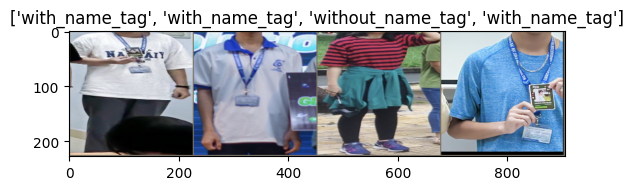

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

TRAIN MODEL

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=70):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

VISUALIZING THE MODEL PREDICTION

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

FINETUNING THE CONvNet

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


TRAIN AND EVALUATe

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

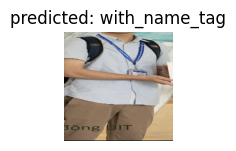

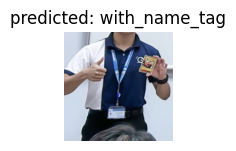

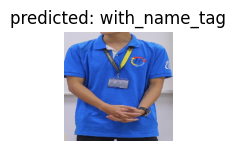

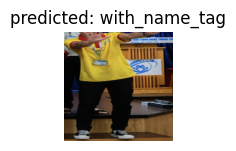

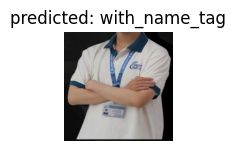

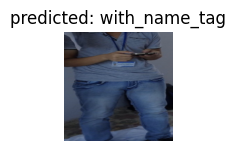

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

SAVE MODEL

In [ ]:
# Save the entire model (including architecture, weights, and optimizer state)
torch.save(model_ft, '/content/drive/MyDrive/machine learning/24.1.model_ft.pt')

Inference on custom images

In [ ]:
model_path ="/content/drive/MyDrive/machine learning/24.1.model_ft.pt"
model_conv = models.resnet18()
  # Load the entire model and check if it's a state dictionary
model_conv  = torch.load(model_path, map_location=torch.device('cpu'))
device = torch.device("cpu")
model_conv = model_conv.to(device)
model_conv .eval()

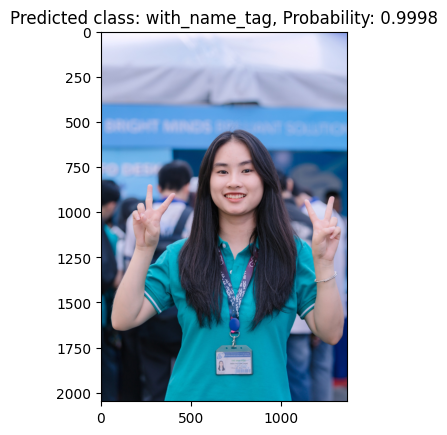

In [32]:
#test on an image

from torchvision import models, transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np

# # Assuming your model is already loaded
# model_conv = ...  # Load your model

# Define the path to your test image
test_image_path = '/content/name_tag.02.jpeg'  # Change this to the path of your test image
class_names = ["with_name_tag", "without_name_tag"]

# Custom transform for preprocessing
custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Custom preprocessing function for a single image
def preprocess_single_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')  # Open the image and convert to RGB
    image = transform(image)  # Apply the specified transform
    return image

# Preprocess the test image
test_image = preprocess_single_image(test_image_path, custom_transform)

# Make sure to add the batch dimension (unsqueeze) if your model expects a batch
test_image = test_image.unsqueeze(0)

# Move the test image to the appropriate device (CPU or GPU)
device = torch.device("cpu") #"cuda:0" if torch.cuda.is_available() else "cpu"
test_image = test_image.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model_conv(test_image)

# Convert the model outputs to probabilities using softmax
probs = torch.nn.functional.softmax(outputs[0], dim=0)

# Display the image and predicted probabilities
plt.imshow(np.array(Image.open(test_image_path)))
plt.title(f'Predicted class: {class_names[probs.argmax().item()]}, Probability: {probs.max().item():.4f}')
plt.show()


In [28]:
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define the path to your test set (with_name_tag and without_name_tag folders)
test_set_path = '/content/UIT/test'

# Custom transform for preprocessing
custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load the test set using torchvision.datasets.ImageFolder
test_dataset = datasets.ImageFolder(root=test_set_path, transform=custom_transform)

# Create a DataLoader for the test set
batch_size = 32  # Adjust the batch size based on your needs
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cpu")  # "cuda:0" if torch.cuda.is_available() else "cpu"
model_conv = model_conv.to(device)

# Set the model to evaluation mode
model_conv.eval()

# Initialize variables for accuracy calculation
correct_predictions = 0
total_images = 0

# Iterate over the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model_conv(inputs)

        # Convert the model outputs to probabilities using softmax
        probs = torch.nn.functional.softmax(outputs, dim=1)

        # Get the predicted classes
        predicted_classes = probs.argmax(dim=1)

        # Update the accuracy variables
        correct_predictions += (predicted_classes == labels).sum().item()
        total_images += labels.size(0)

# Calculate accuracy
accuracy = correct_predictions / total_images
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


Accuracy on the test set: 90.91%


Accuracy on the test set: 90.91%


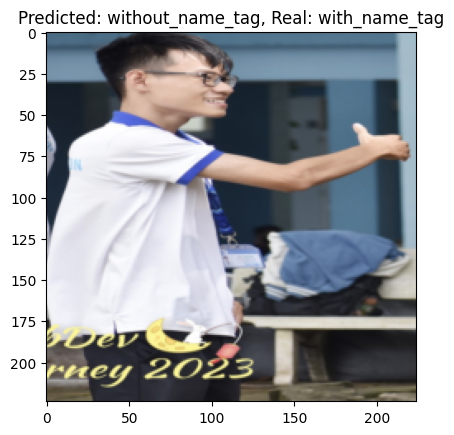

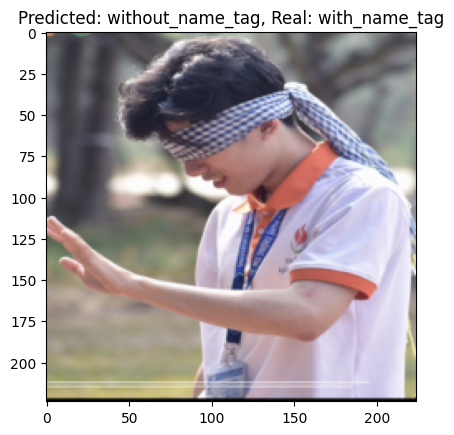

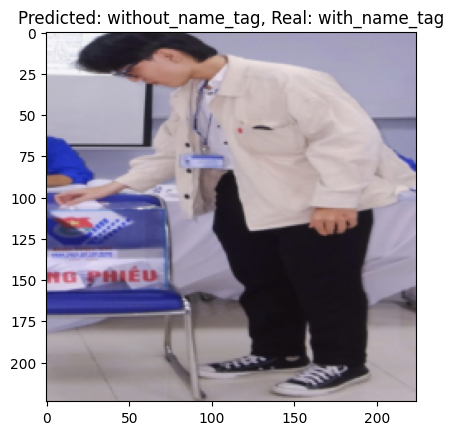

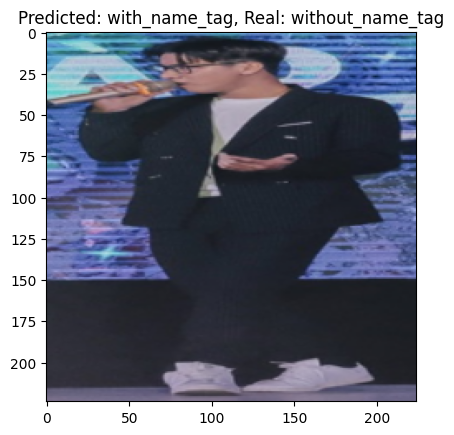

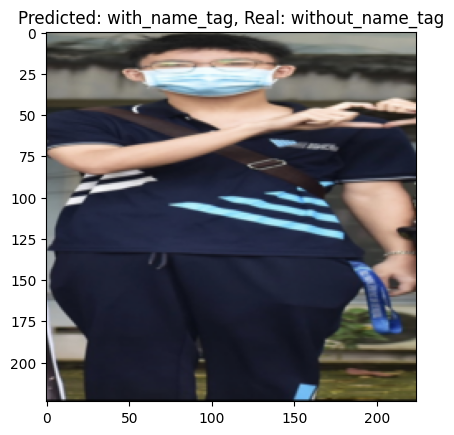

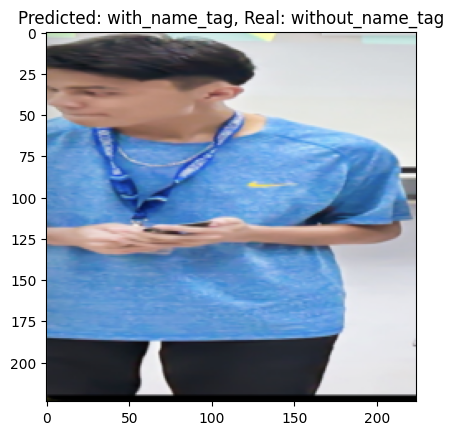

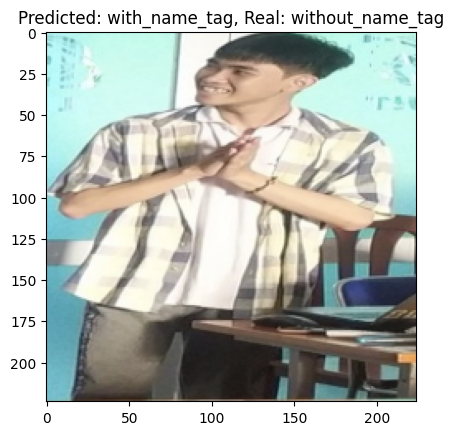

In [31]:
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define the path to your test set (with_name_tag and without_name_tag folders)
test_set_path = '/content/UIT/test'

# Custom transform for preprocessing
custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load the test set using torchvision.datasets.ImageFolder
test_dataset = datasets.ImageFolder(root=test_set_path, transform=custom_transform)

# Create a DataLoader for the test set
batch_size = 32  # Adjust the batch size based on your needs
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cpu")  # "cuda:0" if torch.cuda.is_available() else "cpu"
model_conv = model_conv.to(device)

# Set the model to evaluation mode
model_conv.eval()

# Initialize variables for accuracy calculation
correct_predictions = 0
total_images = 0

# Initialize lists for wrong predictions and real labels
wrong_predictions = []

# Define the inverse normalization transform
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# Iterate over the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model_conv(inputs)

        # Convert the model outputs to probabilities using softmax
        probs = torch.nn.functional.softmax(outputs, dim=1)

        # Get the predicted classes
        predicted_classes = probs.argmax(dim=1)

        # Identify the wrong predictions
        wrong_indices = (predicted_classes != labels).nonzero()
        wrong_predictions.extend([(inputs[i], predicted_classes[i].item(), labels[i].item()) for i in wrong_indices])

        # Update the accuracy variables
        correct_predictions += (predicted_classes == labels).sum().item()
        total_images += labels.size(0)

# Calculate accuracy
accuracy = correct_predictions / total_images
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

# Display information about wrong predictions
for input_image, predicted_label, real_label in wrong_predictions:
    # Inverse normalize the input_image tensor
    input_image = inv_normalize(input_image[0])
    input_image = input_image.cpu().numpy().transpose((1, 2, 0))

    plt.imshow(input_image)
    plt.title(f'Predicted: {class_names[predicted_label]}, Real: {class_names[real_label]}')
    plt.show()